# 3. Linear Regression – Conceptual

In [166]:
from pathlib import Path
import pandas as pd
import statsmodels.api  as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
plt.style.use('classic') # pretty matplotlib plots
sns.set_style(style='white')

warnings.filterwarnings('ignore')

In [167]:
# Classifier stats
# -------------------------------------------------

def prior_error_rate(confusion_mtx):
    """The prior probability that a result is positive"""
    return 1 - (np.sum(confusion_mtx.iloc[1, :]) / np.sum(confusion_mtx.to_numpy()))

def total_error_rate(confusion_mtx):
    """Derive total error rate from confusion matrix"""
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx.to_numpy())

def true_positive_rate(confusion_mtx):
    """or sensitivity: the proportion of actual POSITIVES that are correctly identified as such"""
    return confusion_mtx.iloc[1, 1] / np.sum(confusion_mtx.iloc[1, :])

def true_negative_rate(confusion_mtx):
    """or specificity: the proportion of actual NEGATIVES that are correctly identified as such"""
    return confusion_mtx.iloc[0, 0] / np.sum(confusion_mtx.iloc[0, :])

def positive_predictive_value(confusion_mtx):
    """or precision: the proportion of predicted positives that are correctly predicted"""
    return confusion_mtx.iloc[1, 1] / np.sum(confusion_mtx.iloc[:, 1])

def classifier_stats(confusion_mtx):
    return pd.Series({'prior_error_rate': prior_error_rate(confusion_mtx),
                      'total_error_rate': total_error_rate(confusion_mtx),
                      'true_positive_rate (sensitivity)': true_positive_rate(confusion_mtx),
                      'true_negative_rate (specificity)': true_negative_rate(confusion_mtx),
                      'positive_predictive_value (precision)': positive_predictive_value(confusion_mtx)})

**Q13.** This question should be answered using the Weekly data set, which is part of the ISLR2 package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns? 

In [168]:
path = Path('Data/Weekly.csv')
Weekly = pd.read_csv(path)
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [169]:
Weekly = pd.get_dummies(Weekly, columns=['Direction']).drop('Direction_Down', axis=1)
Weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899,0.555556
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927,0.497132
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000,0.000000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000,0.000000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000,1.000000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000,1.000000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000,1.000000


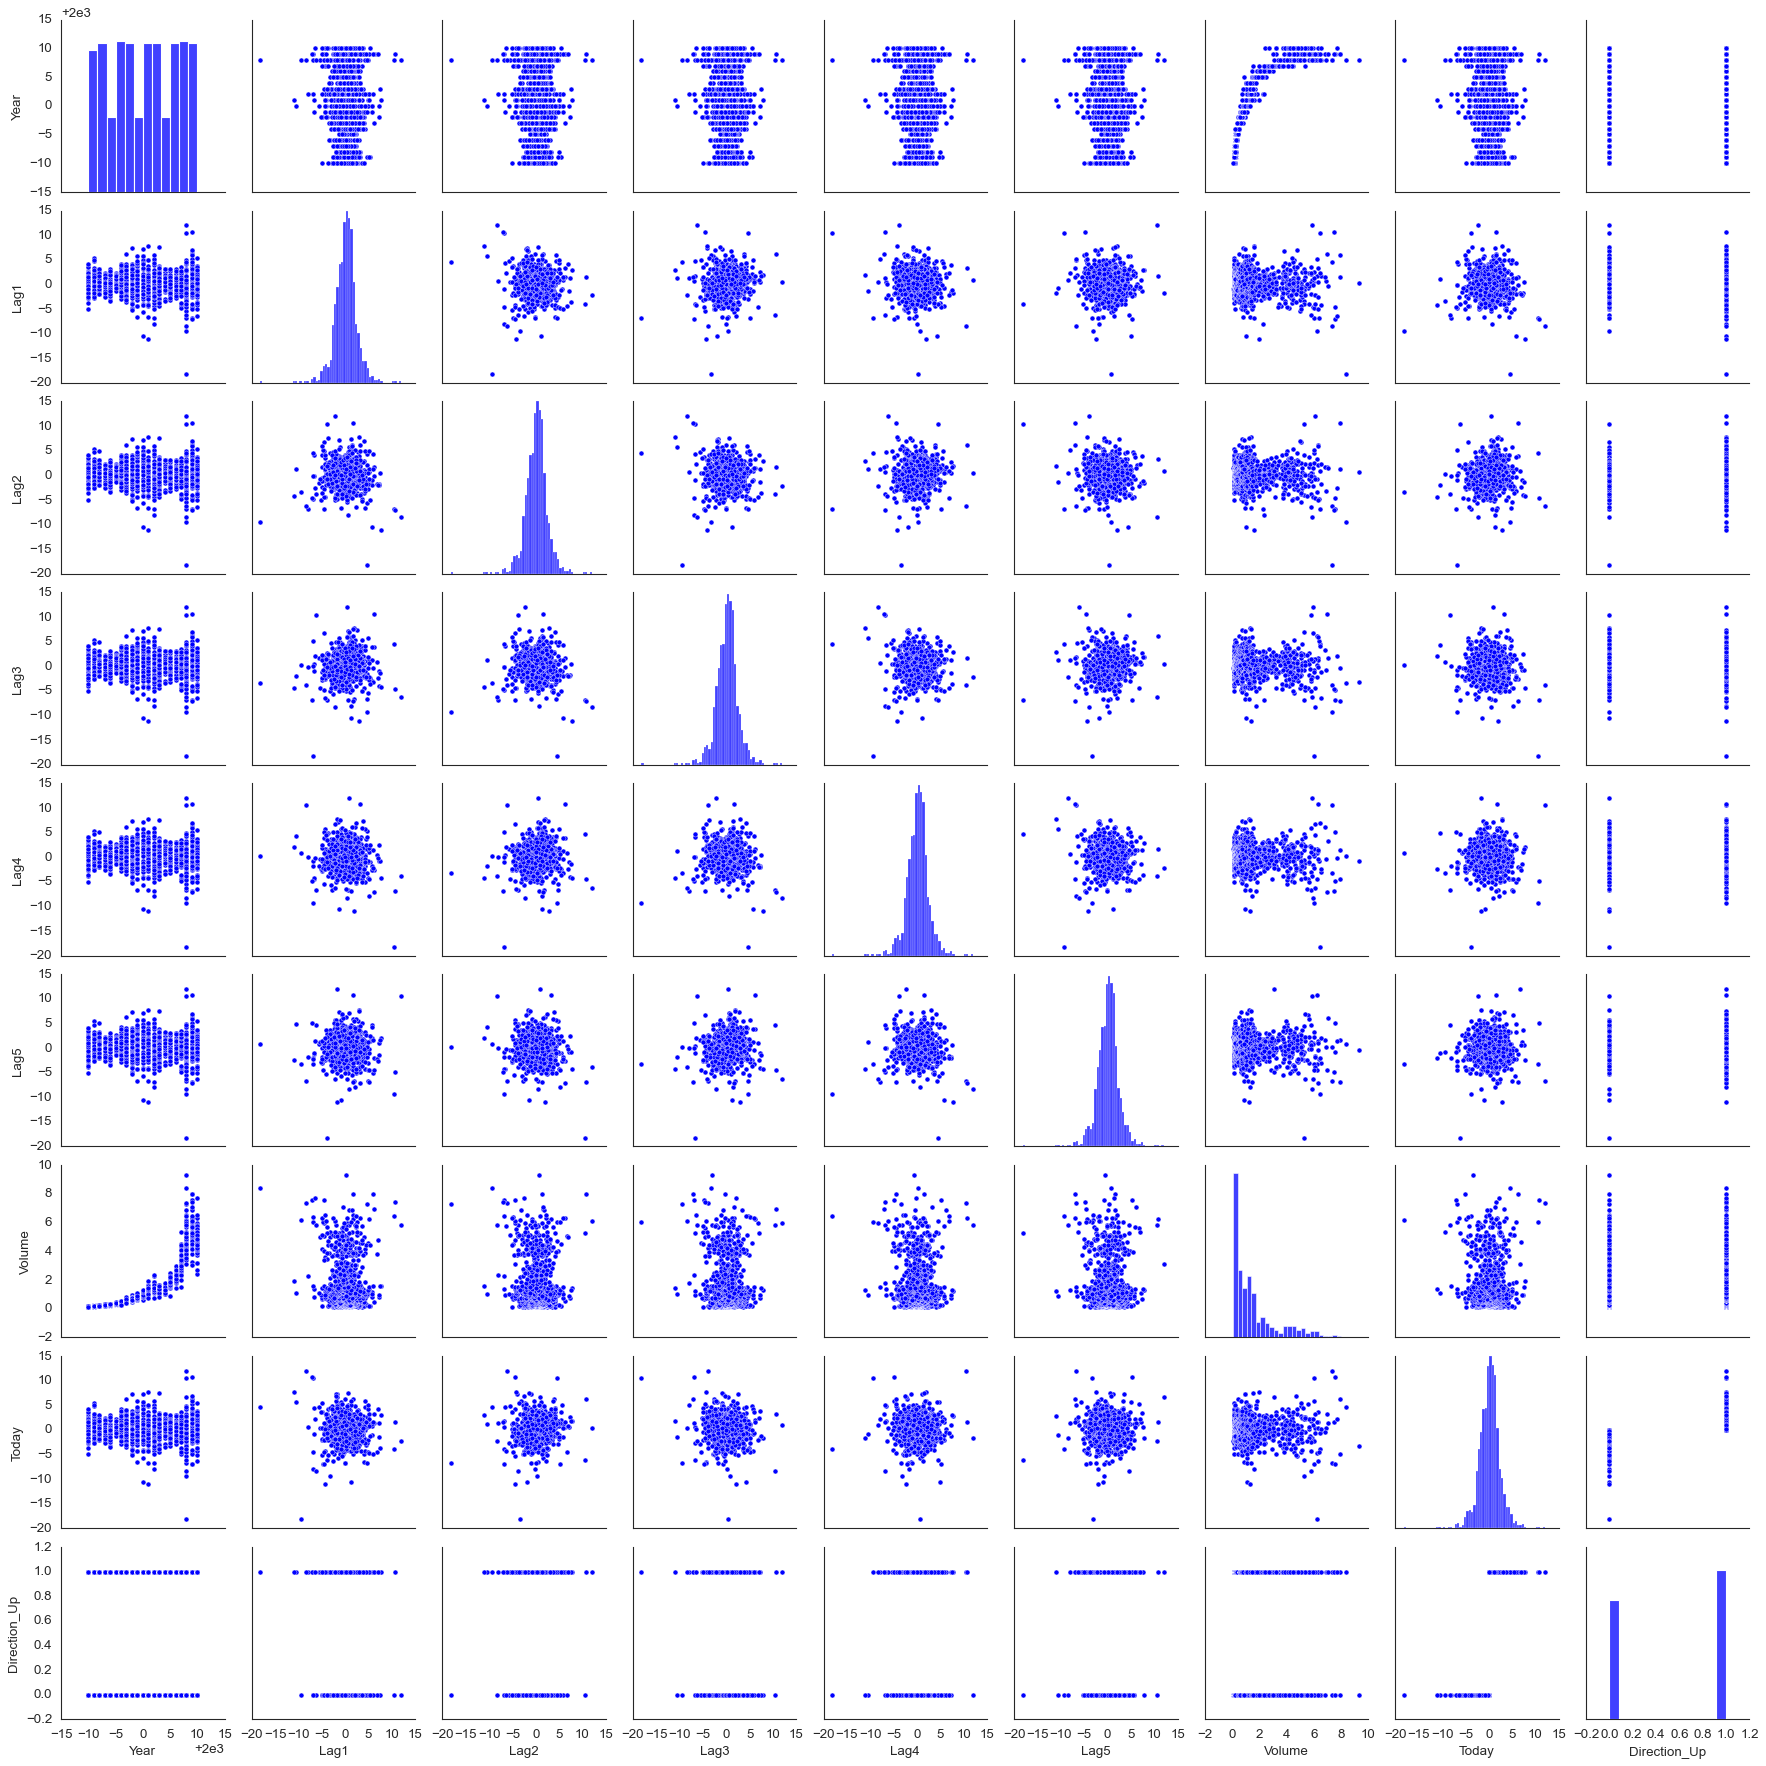

In [170]:
sns.pairplot(Weekly);

In [171]:
corrM = Weekly.corr()
corrM.style.background_gradient(cmap='coolwarm').set_precision(2)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
Year,1.00,-0.03,-0.03,-0.03,-0.03,-0.03,0.84,-0.03,-0.02
Lag1,-0.03,1.00,-0.07,0.06,-0.07,-0.01,-0.06,-0.08,-0.05
Lag2,-0.03,-0.07,1.00,-0.08,0.06,-0.07,-0.09,0.06,0.07
Lag3,-0.03,0.06,-0.08,1.00,-0.08,0.06,-0.07,-0.07,-0.02
Lag4,-0.03,-0.07,0.06,-0.08,1.00,-0.08,-0.06,-0.01,-0.02
Lag5,-0.03,-0.01,-0.07,0.06,-0.08,1.00,-0.06,0.01,-0.02
Volume,0.84,-0.06,-0.09,-0.07,-0.06,-0.06,1.00,-0.03,-0.02
Today,-0.03,-0.08,0.06,-0.07,-0.01,0.01,-0.03,1.00,0.72
Direction_Up,-0.02,-0.05,0.07,-0.02,-0.02,-0.02,-0.02,0.72,1.00


The correlations between the “lag” variables and today’s returns are close to zero. The only substantial correlation is between “Year” and “Volume”. The pairplot also suggest, that there is a logistic relationship between Today and Direction_Up.

(b) Use the full data set to perform a logistic regression with Direction as the response and the ﬁve lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically signiﬁcant? If so, which ones?

In [172]:
df = sm.add_constant(Weekly)
X = df[['const', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
y = df['Direction_Up']

log_reg = sm.Logit(y, X).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 1.925080
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Direction_Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Tue, 05 Oct 2021   Pseudo R-squ.:                     inf
Time:                        09:36:20   Log-Likelihood:                -2096.4
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

It seems that “Lag2” is the only predictor statistically significant as its p-value is less than 0.05.

(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [173]:
log_reg.pred_table()

array([[ 54., 430.],
       [ 48., 557.]])

In [174]:
# Formatting confusion matrix
cm_df = pd.DataFrame(log_reg.pred_table())
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
cm_df


,Predicted 0,Predicted 1
Actual 0,54.0,430.0
Actual 1,48.0,557.0


In [175]:
classifier_stats(cm_df)

prior_error_rate                         0.444444
total_error_rate                         0.438935
true_positive_rate (sensitivity)         0.920661
true_negative_rate (specificity)         0.111570
positive_predictive_value (precision)    0.564336
dtype: float64

We may conclude that the percentage of correct predictions on the training data is (54+557)/1089 wich is equal to 56.1065197%. In other words 43.8934803% is the training error rate, which is often overly optimistic. We could also say that for weeks when the market goes up, the model is right 92.0661157% of the time (557/(48+557)). For weeks when the market goes down, the model is right only 11.1570248% of the time (54/(54+430)).



(d) Now ﬁt the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010). 

In [176]:
df_train = df[(df.Year >= 1990) & (df.Year <= 2008)]
df_test = df.drop(df_train.index)

X = df_train[['const', 'Lag2']]
y = df_train['Direction_Up']

log_reg2 = sm.Logit(y, X).fit()
log_reg2.summary()

Optimization terminated successfully.
         Current function value: 0.888927
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Direction_Up   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Oct 2021   Pseudo R-squ.:                     inf
Time:                        09:36:20   Log-Likelihood:                -875.59
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.029      2.024      0.043       0.002       0.114
==============================================================================
"""

In [177]:
y_pred_logit   = (log_reg2.predict(df_test[['const', 'Lag2']]) > 0.5).astype(int)

cm_df = pd.DataFrame(log_reg2.pred_table())
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,23.0,418.0
Actual 1,20.0,524.0


In [178]:
table = np.histogram2d(np.array(df_test.Direction_Up), np.array(y_pred_logit), bins=2)[0]



In [179]:
cm_df = pd.DataFrame(table)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,9.0,34.0
Actual 1,5.0,56.0


In [180]:
log_stats = classifier_stats(cm_df)
log_stats

prior_error_rate                         0.413462
total_error_rate                         0.375000
true_positive_rate (sensitivity)         0.918033
true_negative_rate (specificity)         0.209302
positive_predictive_value (precision)    0.622222
dtype: float64

In this case, we may conclude that the percentage of correct predictions on the test data is (9+56)/104 wich is equal to 62.5%. In other words 37.5% is the test error rate. We could also say that for weeks when the market goes up, the model is right 91.8032787% of the time (56/(56+5)). For weeks when the market goes down, the model is right only 20.9302326% of the time (9/(9+34)).

(e) Repeat (d) using LDA.

In [181]:
idx = df[(df.Year >= 1990) & (df.Year <= 2008)].index
df_x_train = np.array(df.loc[idx]['Lag2']).reshape(-1,1)
df_y_train = np.array(df.loc[idx]['Direction_Up'])
df_x_test = np.array(df.drop(idx)['Lag2']).reshape(-1,1)
df_y_test = np.array(df.drop(idx)['Direction_Up'])

In [182]:
# Fit model
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(df_x_train, df_y_train)

# Predict
y_pred_lda = lda_model.predict(df_x_test)

In [183]:
table = np.histogram2d(np.array(df_y_test), np.array(y_pred_lda), bins=2)[0]

cm_df = pd.DataFrame(table)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,9.0,34.0
Actual 1,5.0,56.0


In [184]:
lda_stats = classifier_stats(cm_df)
lda_stats

prior_error_rate                         0.413462
total_error_rate                         0.375000
true_positive_rate (sensitivity)         0.918033
true_negative_rate (specificity)         0.209302
positive_predictive_value (precision)    0.622222
dtype: float64

In this case, we may conclude that the percentage of correct predictions on the test data is 62.5%. In other words 37.5% is the test error rate. We could also say that for weeks when the market goes up, the model is right 91.8032787% of the time. For weeks when the market goes down, the model is right only 20.9302326% of the time. These results are very close to those obtained with the logistic regression model which is not surpising.

(f) Repeat (d) using QDA.

In [185]:
# Fit model
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(df_x_train, df_y_train)

# Predict
y_pred_qda = qda_model.predict(df_x_test)

In [186]:
table = np.histogram2d(np.array(df_y_test), np.array(y_pred_qda), bins=2)[0]

cm_df = pd.DataFrame(table)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,0.0,43.0
Actual 1,0.0,61.0


In [187]:
qda_stats = classifier_stats(cm_df)
qda_stats

prior_error_rate                         0.413462
total_error_rate                         0.413462
true_positive_rate (sensitivity)         1.000000
true_negative_rate (specificity)         0.000000
positive_predictive_value (precision)    0.586538
dtype: float64

In this case, we may conclude that the percentage of correct predictions on the test data is 58.6538462%. In other words 41.3461538% is the test error rate. We could also say that for weeks when the market goes up, the model is right 100% of the time. For weeks when the market goes down, the model is right only 0% of the time. We may note, that QDA achieves a correctness of 58.6538462% even though the model chooses “Up” the whole time !

(g) Repeat (d) using KNN with K = 1

In [188]:
# Fit model
knn = KNeighborsClassifier(n_neighbors=1)
knn_model = knn.fit(df_x_train, df_y_train)

# Predict
y_pred_knn = knn_model.predict(df_x_test)

In [189]:
table = np.histogram2d(np.array(df_y_test), np.array(y_pred_knn), bins=2)[0]

cm_df = pd.DataFrame(table)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,21.0,22.0
Actual 1,31.0,30.0


In [190]:
knn_stats = classifier_stats(cm_df)
knn_stats

prior_error_rate                         0.413462
total_error_rate                         0.509615
true_positive_rate (sensitivity)         0.491803
true_negative_rate (specificity)         0.488372
positive_predictive_value (precision)    0.576923
dtype: float64

(h) Repeat (d) using naive Bayes.

In [191]:
# Fit model
nb = GaussianNB()
nb_model = nb.fit(df_x_train, df_y_train)

# Predict
y_pred_nb = nb_model.predict(df_x_test)

In [192]:
table = np.histogram2d(np.array(df_y_test), np.array(y_pred_nb), bins=2)[0]

cm_df = pd.DataFrame(table)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,0.0,43.0
Actual 1,0.0,61.0


In [193]:
nb_stats = classifier_stats(cm_df)
nb_stats

prior_error_rate                         0.413462
total_error_rate                         0.413462
true_positive_rate (sensitivity)         1.000000
true_negative_rate (specificity)         0.000000
positive_predictive_value (precision)    0.586538
dtype: float64

(i) Which of these methods appears to provide the best results on this data?

In [200]:
stats = pd.DataFrame({'logit': log_stats,
                        'lda'  : lda_stats,
                        'qda'  : qda_stats,
                        'knn'  : knn_stats,
                        'nb'   : nb_stats})
stats

,logit,lda,qda,knn,nb
prior_error_rate,0.413462,0.413462,0.413462,0.413462,0.413462
total_error_rate,0.375000,0.375000,0.413462,0.509615,0.413462
true_positive_rate (sensitivity),0.918033,0.918033,1.000000,0.491803,1.000000
true_negative_rate (specificity),0.209302,0.209302,0.000000,0.488372,0.000000
positive_predictive_value (precision),0.622222,0.622222,0.586538,0.576923,0.586538


If we compare the test error rates, we see that logistic regression and LDA have the minimum error rates.

(j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [320]:
def compare_methods(cols):
    # Preparing data
    data = df
    data['Year*Volume'] = data['Year'] * data['Volume']
    data['Year*Lag2'] = data['Year'] * data['Lag2']

    idx = data[(data.Year >= 1990) & (data.Year <= 2008)].index
    df_x_train = np.array(data.loc[idx][cols])
    df_y_train = np.array(data.loc[idx]['Direction_Up'])
    df_x_test = np.array(data.drop(idx)[cols])
    df_y_test = np.array(data.drop(idx)['Direction_Up'])

    # First investigate KNN and select the optimal number of k and p
    df_x_train_knn = df_x_train
    df_x_test_knn = df_x_test
    knn_errors = dict()
    for k in range(1,25):
        # Fit model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn_model = knn.fit(df_x_train_knn, df_y_train)

        # Predict
        y_pred_knn = knn_model.predict(df_x_test_knn)

        table = np.histogram2d(np.array(df_y_test), np.array(y_pred_knn), bins=2)[0]

        cm_df = pd.DataFrame(table)
        cm_df.columns = ['Predicted 0', 'Predicted 1']
        cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
        knn_errors[k] = total_error_rate(cm_df)
    
    plt.plot(knn_errors.keys(), knn_errors.values())
    plt.show()
    print("Number of neighbors with the lowest error rate is: ", min(knn_errors, key=knn_errors.get))
    k = min(knn_errors, key=knn_errors.get)

    #+ LOG
    #Fit a model
    log_reg2 = sm.Logit(df_y_train, sm.add_constant(df_x_train)).fit()

    # Predict
    y_pred_logit   = (log_reg2.predict(sm.add_constant(df_x_test)) > 0.5).astype(int)

    table = np.histogram2d(np.array(df_y_test), np.array(y_pred_logit), bins=2)[0]

    cm_df = pd.DataFrame(table)
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    log_stats = classifier_stats(cm_df)

    #+ LDA
    # Fit a model
    lda = LinearDiscriminantAnalysis()
    lda_model = lda.fit(df_x_train, df_y_train)

    # Predict
    y_pred_lda = lda_model.predict(df_x_test)

    table = np.histogram2d(np.array(df_y_test), np.array(y_pred_lda), bins=2)[0]

    cm_df = pd.DataFrame(table)
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    lda_stats = classifier_stats(cm_df)

    #+ QDA
    # Fit a model
    qda = QuadraticDiscriminantAnalysis()
    qda_model = qda.fit(df_x_train, df_y_train)

    # Predict
    y_pred_qda = qda_model.predict(df_x_test)

    table = np.histogram2d(np.array(df_y_test), np.array(y_pred_qda), bins=2)[0]

    cm_df = pd.DataFrame(table)
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    qda_stats = classifier_stats(cm_df)

    #+ KNN
    # Fit model
    knn = KNeighborsClassifier(n_neighbors=13)
    knn_model = knn.fit(df_x_train, df_y_train)

    # Predict
    y_pred_knn = knn_model.predict(df_x_test)

    table = np.histogram2d(np.array(df_y_test), np.array(y_pred_knn), bins=2)[0]

    cm_df = pd.DataFrame(table)
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    knn_stats = classifier_stats(cm_df)

    #+ NB
    # Fit model
    nb = GaussianNB()
    nb_model = nb.fit(df_x_train, df_y_train)

    # Predict
    y_pred_nb = nb_model.predict(df_x_test)

    table = np.histogram2d(np.array(df_y_test), np.array(y_pred_nb), bins=2)[0]

    cm_df = pd.DataFrame(table)
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    nb_stats = classifier_stats(cm_df)

    stats = pd.DataFrame({'logit': log_stats,
                        'lda'  : lda_stats,
                        'qda'  : qda_stats,
                        'knn'  : knn_stats,
                        'nb'   : nb_stats})
    return stats

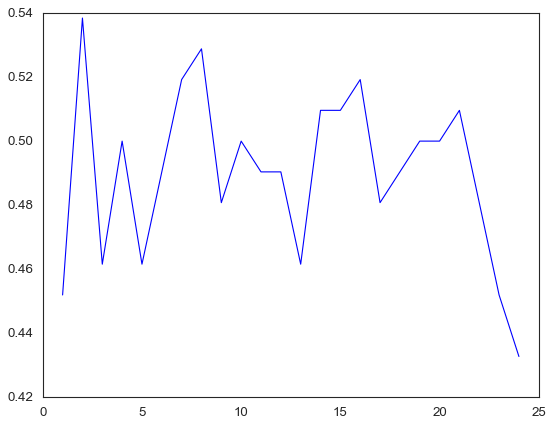

Number of neighbors with the lowest error rate is:  24
Optimization terminated successfully.
         Current function value: 2.248017
         Iterations 5
Stats for where predictors are Year, Lag2, Volume, Year*Volume, Year*Lag2:


,logit,lda,qda,knn,nb
prior_error_rate,0.413462,0.413462,0.413462,0.413462,0.413462
total_error_rate,0.557692,0.557692,0.461538,0.461538,0.567308
true_positive_rate (sensitivity),0.377049,0.377049,0.475410,0.442623,0.032787
true_negative_rate (specificity),0.534884,0.534884,0.627907,0.674419,1.000000
positive_predictive_value (precision),0.534884,0.534884,0.644444,0.658537,1.000000


In [321]:
stats = compare_methods(['Year', 'Lag2', 'Volume', 'Year*Volume', 'Year*Lag2'])
print('Stats for where predictors are Year, Lag2, Volume, Year*Volume, Year*Lag2:')
stats

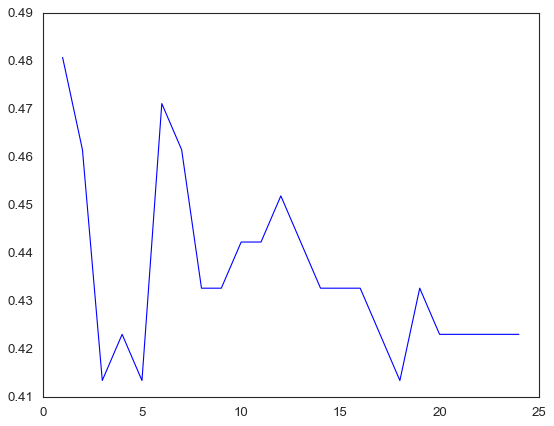

Number of neighbors with the lowest error rate is:  3
Optimization terminated successfully.
         Current function value: 2.117032
         Iterations 5
Stats for where predictors are Year, Lag2, Year*Lag2:


,logit,lda,qda,knn,nb
prior_error_rate,0.413462,0.413462,0.413462,0.413462,0.413462
total_error_rate,0.451923,0.442308,0.548077,0.442308,0.538462
true_positive_rate (sensitivity),0.688525,0.704918,0.377049,0.622951,0.442623
true_negative_rate (specificity),0.348837,0.348837,0.558140,0.465116,0.488372
positive_predictive_value (precision),0.600000,0.605634,0.547619,0.622951,0.551020


In [322]:
stats = compare_methods(['Year', 'Lag2', 'Year*Lag2'])
print('Stats for where predictors are Year, Lag2, Year*Lag2:')
stats

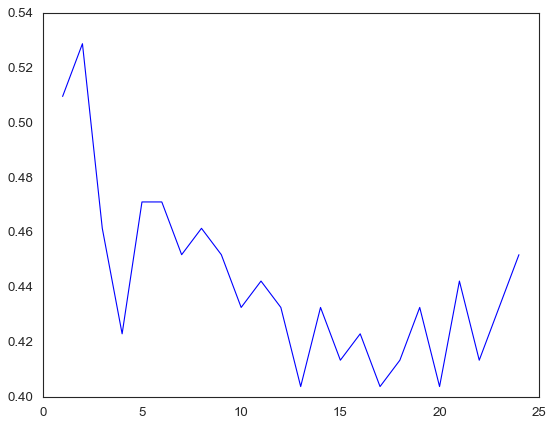

Number of neighbors with the lowest error rate is:  13
Optimization terminated successfully.
         Current function value: 0.888927
         Iterations 4
Stats for where predictors is Lag2:


,logit,lda,qda,knn,nb
prior_error_rate,0.413462,0.413462,0.413462,0.413462,0.413462
total_error_rate,0.375000,0.375000,0.413462,0.403846,0.413462
true_positive_rate (sensitivity),0.918033,0.918033,1.000000,0.688525,1.000000
true_negative_rate (specificity),0.209302,0.209302,0.000000,0.465116,0.000000
positive_predictive_value (precision),0.622222,0.622222,0.586538,0.646154,0.586538


In [323]:
stats = compare_methods(['Lag2'])
print('Stats for where predictors is Lag2:')
stats